In [2]:
import xmltodict
import json
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

# 1. add images directory to data 

annotations_p = Path('data/annotations.xml')


with open(annotations_p) as fd:
    doc = xmltodict.parse(fd.read())

doc["annotations"].keys()

dict_keys(['version', 'meta', 'image'])

In [3]:
image_id = -2
doc["annotations"]["image"][image_id]

{'@id': '1',
 '@name': 'SA_20211012-165505_incision_crop_0.jpg',
 '@subset': 'default',
 '@task_id': '337',
 '@width': '233',
 '@height': '70',
 'polyline': [{'@label': 'Stitch',
   '@occluded': '0',
   '@source': 'manual',
   '@points': '173.02,22.97;173.02,51.65',
   '@z_order': '0'},
  {'@label': 'Incision',
   '@occluded': '0',
   '@source': 'manual',
   '@points': '17.69,38.60;215.06,35.01',
   '@z_order': '0',
   'attribute': {'@name': 'Type', '#text': 'Single'}},
  {'@label': 'Stitch',
   '@occluded': '0',
   '@source': 'manual',
   '@points': '138.16,22.97;139.18,50.90',
   '@z_order': '0'}]}

In [3]:
data = {}

for image_id, image in enumerate(doc["annotations"]["image"]):
  if "polyline" in image:
      polylines = []
      labels = []
      if type(image['polyline']) == dict:
         labels.append(image['polyline']['@label'])
      else:
        labels = [pl['@label'] for pl in image['polyline']]
      for pline in image["polyline"]:
        if type(image['polyline']) == dict: # not a list of dicts ... single item
            pts = [pt.split(",") for pt in image['polyline']["@points"].split(";")]
            polylines.append(pts)
            break  
        pts = [pt.split(",") for pt in pline["@points"].split(";")]  # extract coodrinates
        polylines.append(pts)

      data[image_id] = {'label': labels, 'points': polylines, 'file': image['@name']}
        #plt.plot(pts[:,0], pts[:, 1])

json_p = Path('data/data.json')
with open(json_p, 'w') as f: 
   json.dump(data, f)

max. incision segments: 15
max. stich counts: 9


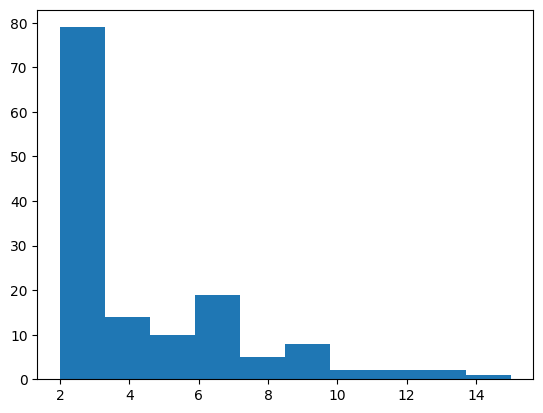

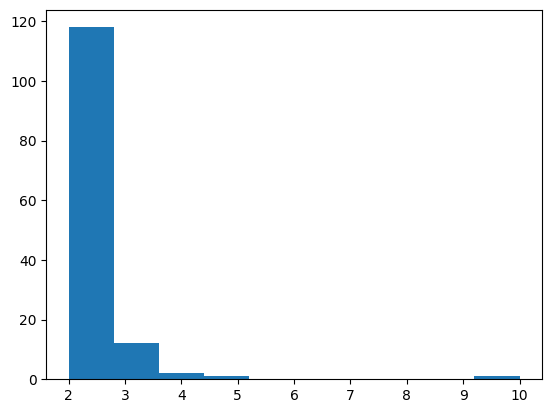

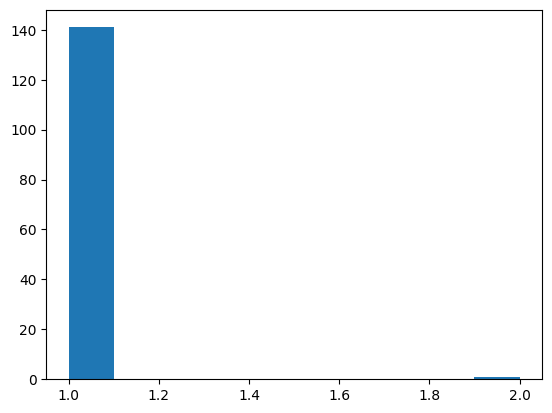

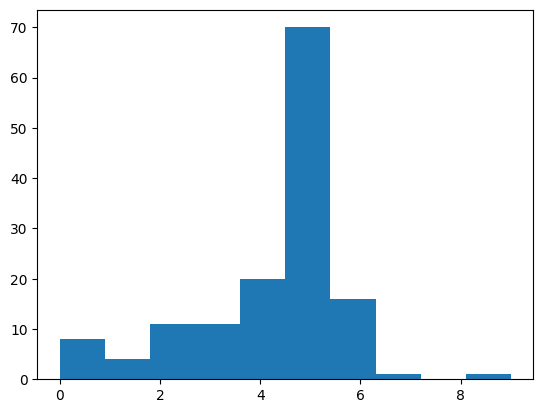

In [4]:
# validate data
incisions_len = {}
stitches_len = {}
incisions_count = {}
stitches_count = {}
for image_id, image in data.items():
    count = len(image['label'])
    if len(image['points']) != count: 
        print(f"wrong number of points for image id {image_id}")
    incisions_count[image_id] = 0
    stitches_count[image_id] = 0
    for lidx, l in enumerate(image['label']):
        pts = image['points'][lidx]
        if l == 'Stitch': 
            stitches_len[image_id] = len(pts)
            stitches_count[image_id] += 1
        elif l == 'Incision':
            incisions_len[image_id] = len(pts)
            incisions_count[image_id] += 1

plt.hist(incisions_len.values())
# plt.title('Incision lengths')
plt.figure()
plt.hist(stitches_len.values())
# plt.title('Stitch lengths')
plt.figure()
plt.hist(incisions_count.values())
# plt.title('Incision counts')
plt.figure()
plt.hist(stitches_count.values())
# plt.title('Stitch counts')
print(f"max. incision segments: {np.max(list(incisions_len.values()))}")
print(f"max. stich counts: {np.max(list(stitches_count.values()))}")

In [6]:
# FILTER DATA
# data_f = 

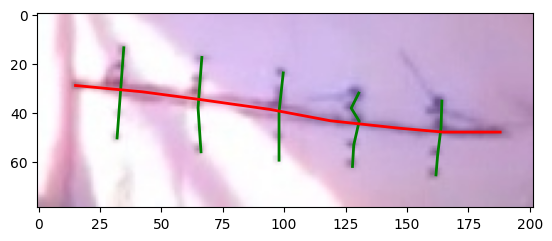

In [11]:
import matplotlib.image as mpimg

def visualize(data, image_id):

    color = {
        'Incision': 'red',
        'Stitch': 'green'
    }

    image_path = Path('data/images/default')/data[image_id]['file']
    image = mpimg.imread(image_path)
    
    fig, ax = plt.subplots()
    ax.imshow(image)

    for idx, label in enumerate(data[image_id]['label']):
        points = data[image_id]['points'][idx]
        x_coords, y_coords = zip(*points)
        x_coords = np.array(x_coords, dtype=float)
        y_coords = np.array(y_coords, dtype=float)
        ax.plot(x_coords, y_coords, color=color[label], linewidth=2)
    # Show the plot
    plt.show()


visualize(data, 120)

height: mean=90.01408450704226, median=81.5, min=18(75), max=302(183)
width: mean=273.88732394366195, median=259.0, min=67(167), max=1118(183)
ratio: mean=0.34830170066033916, median=0.3240223463687151, min=0.17719298245614035(98), max=2.7941176470588234(56)


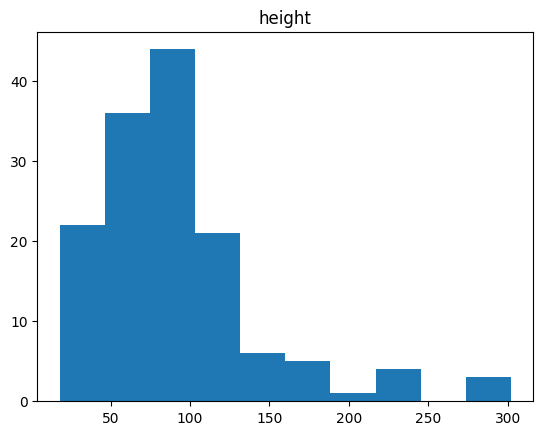

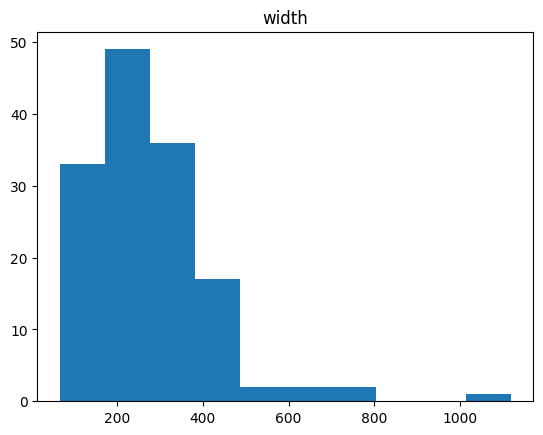

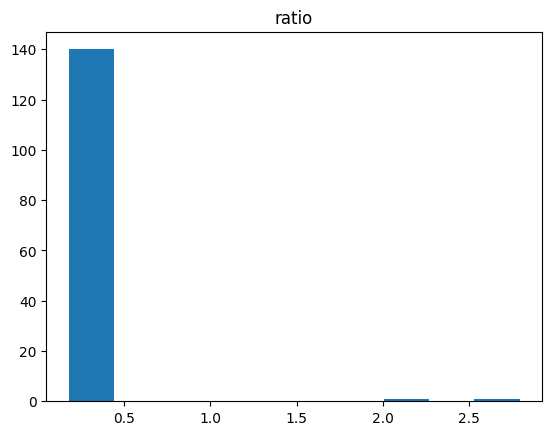

In [8]:
# IMAGE SIZES AND BASIC STATS
hs = {}
ws = {}
ratio = {}
for image_id in data:
    image_path = Path('data/images/default')/data[image_id]['file']
    image = mpimg.imread(image_path)
    hs[image_id] = image.shape[0]
    ws[image_id] = image.shape[1]
    ratio[image_id] = image.shape[0]/image.shape[1]

for x in [('height', hs),('width', ws),('ratio', ratio)]:
    y = list(x[1].values())
    ids = list(x[1].keys())
    print(f"{x[0]}: mean={np.mean(y)}, median={np.median(y)}, min={np.min(y)}({ids[np.argmin(y)]}), max={np.max(y)}({ids[np.argmax(y)]})")
    plt.figure()
    plt.hist(y)
    # plt.title(x[0])